In [211]:
import shelve
import os
import torch
import warnings
import random
from torch.utils.data import Dataset

In [212]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [90]:
class ModelData:
    def read_data(self, data_identifier: str, data_type: str):
        file_path = self.check_identifier(data_identifier)
        
        f = shelve.open(file_path[:-3], 'r')
        if data_type == 'train':
            data = f['train_dict']
        elif data_type == 'test':
            data = f['train_dict']
        else:
            raise Exception("invalid data type requested")
        f.close()
        return data
    
    def check_identifier(self, data_identifier: str):
        file_path = data_identifier
        if 'Data' not in data_identifier:
            file_path = os.path.join(os.getcwd(), 'Data', 'Data-'+data_identifier+'.db')
        
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} not found")
        else:
            return file_path
        
        
    def labels_to_index_dict(self, data: dict):
        return {label : indx for indx, label in enumerate(data.keys())}
    
    def index_to_labels_dict(self, labels_to_index_dict: dict):
        return {indx : label for label, indx in labels_to_index_dict.items()}
    
    def get_nclasses(self, data: dict):
        return len(data.keys())
    
    def get_sample_sizes(self, data: dict, index_to_label_dict: dict):
        sample_sizes = []
        for indx in range(len(data)):
            label = index_to_label_dict.get(indx, None)
            sample_sizes.append(data[label].shape[1])
        return sample_sizes

    def get_max_batch_size(self, sample_sizes: list):
        return min(sample_sizes)*len(sample_sizes)
    
    def get_max_data_dim(self, data: dict):
        data_dims = [values.shape[0] for values in data.values()]
        return max(data_dims)

In [91]:
class TrainData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'train')
        self.nclasses = self.get_nclasses(self.data)
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)
        self.max_batch_size = self.get_max_batch_size(self.sample_sizes)
        

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)

In [92]:
class TestData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'test')
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.nclasses = self.get_nclasses(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)
        

In [93]:
class TrainLoader:
    def __init__(self, data_source, batch_size: int = 0, n_iter: int = 1, shuffle: bool = False):
        self.data_source = data_source
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.returned_index = 0
        self.adjusted_batch_size = self.adjust_batch_size(batch_size)
        self.nsamples = self.get_nsamples()
        self.class_indices_r = self.get_randomized_class_indices()
        self.sample_indices_r = self.get_randomized_sample_indices()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.n_iter > 0 and self.returned_index < self.adjusted_batch_size:
            c_indx, s_indx = divmod(self.returned_index, self.nsamples)
            self.returned_index += 1
            self.update_batch()
            if self.shuffle:
                indx = self.class_indices_r[c_indx], random.randrange(self.data_source.sample_sizes[c_indx])
                return self.data_source[indx]
            else:
                indx = self.class_indices_r[c_indx], (self.sample_indices_r[c_indx] + s_indx)
                return self.data_source[indx]
        else:
            raise StopIteration

    def update_batch(self):
        if self.returned_index == self.adjusted_batch_size:
            self.n_iter -= 1
            random.shuffle(self.class_indices_r)
            self.sample_indices_r = self.get_randomized_sample_indices()
            self.returned_index = 0
        
    def adjust_batch_size(self, batch_size: int):
        adjusted_batch_size = min(max(batch_size//self.data_source.nclasses, 1) * self.data_source.nclasses, self.data_source.max_batch_size)
        if adjusted_batch_size != batch_size:
            warnings.warn(f"batch size adjusted to {adjusted_batch_size}")
        return adjusted_batch_size

    def get_nsamples(self):
        return (self.adjusted_batch_size//self.data_source.nclasses)
    
    def get_randomized_class_indices(self):
        class_indices_r = [*range(self.data_source.nclasses)]
        random.shuffle(class_indices_r)
        return class_indices_r
    
    def get_randomized_sample_indices(self):
        sample_indices_r = []
        for indx in self.class_indices_r:
            random_start_limit = self.data_source.sample_sizes[indx] - self.nsamples
            sample_indices_r.append(random.randint(0, random_start_limit))
        return sample_indices_r
    
    def get_batch_size(self):
        return self.adjusted_batch_size

In [94]:
class TestLoader:
    def __init__(self, data_source):
        self.data_source = data_source
        self.returned_class_indx = 0
        self.returned_sample_indx = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.returned_class_indx < self.data_source.nclasses and self.returned_sample_indx < self.data_source.sample_sizes[self.returned_class_indx]:
            indx = self.returned_class_indx, self.returned_sample_indx
            self.returned_sample_indx += 1
            self.update_class()
            return self.data_source[indx]
        else:
            raise StopIteration
    
    def update_class(self):
        if self.returned_sample_indx == self.data_source.sample_sizes[self.returned_class_indx]:
            self.returned_class_indx += 1
            self.returned_sample_indx = 0

    def get_index_to_class_dict(self):
        return self.data_source.index_to_labels
    
    def get_class_to_index_dict(self):
        return self.data_source.labels_to_index

In [10]:
train_inputs = TrainData('May04-2357')
train_loader = TrainLoader(train_inputs, batch_size=128, n_iter=2)
test_inputs = TestData('May04-2357')
test_loader = TestLoader(test_inputs)

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.debug('This message should appear on the console')
logging.info('So should this')
logging.warning('And this, too')

DEBUG:This message should appear on the console
INFO:So should this


In [5]:
import torch
from torch.nn.functional import normalize
from torch.linalg import multi_dot

def get_init_batch(train_inputs, n_batches: int=1):
    data_dim = train_inputs.get_data_dim()
    batch_size = int(0.25*len(train_inputs))
    train_loader = TrainLoader(train_inputs, batch_size=batch_size, n_iter=n_batches)
    adjusted_batch_size = train_loader.get_batch_size()
    init_tensor = torch.empty((n_batches, adjusted_batch_size, data_dim))
    for i, input in enumerate(train_loader):
        batch_number, sample_number = divmod(i, adjusted_batch_size)
        init_tensor[batch_number, sample_number, :] = torch.flatten(input, start_dim=0)
    return init_tensor

def get_effective_dim(S: torch.Tensor):
    assert S.dim() == 1, "singular values must be in 1D vector"
    S_n = S**2/torch.sum(S**2)
    n_comp = 0
    for i in range(len(S_n)):
        if torch.sum(S_n[:i]) > 0.95:
            n_comp = i+1
            break
    return n_comp

def randomizer_matrix(m: int, n: int):
    assert m >= n, f"m={m} should be greater than or equal to n={n}"
    _, _, V = torch.pca_lowrank(torch.rand(n, n), q=n)
    if m > n:
        random_matrix = normalize(torch.randn(m-n, n), p=2, dim=1)
        Vc = torch.mm(random_matrix, V)
        return torch.vstack((V, Vc))
    else:
        return V

def input_svd_matrices(init_batch: torch.Tensor):
    _, S, V = torch.pca_lowrank(init_batch)
    effective_dim = get_effective_dim(S)
    return V[:, :effective_dim], S[:effective_dim], effective_dim

def initialize_network_connections(layer_dims: list, data_identifier: str):
    train_inputs = TrainData(data_identifier)
    init_batch = get_init_batch(train_inputs)
    left_matrix, sigma, n = input_svd_matrices(init_batch)
    sigma_r = sigma**(-1/len(layer_dims))
    
    for dim in layer_dims:
        right_matrix = randomizer_matrix(layer_dims[dim], n)
        w = multi_dot([left_matrix, torch.diag(sigma_r), right_matrix.T])
        w_n = normalize(w, p=2.0, dim=1)
        left_matrix = right_matrix
    return None


In [96]:
train_inputs = TrainData('May04-2357')
init_tensor = get_init_batch(train_inputs, n_batches=3)
print(init_tensor.shape)

torch.Size([3, 64, 102])


/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_43991/2289762838.py:39: UserWarning: batch size adjusted to 64
  warnings.warn(f"batch size adjusted to {adjusted_batch_size}")


In [163]:
from torch import nn

class Hash(nn.Module):
    def __init__(self, input_size: int, hash_length: int):
        super().__init__()
        self.fc = nn.Linear(input_size, hash_length, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        assert x.dim() == 3
        out = self.fc(x)
        out = self.activation(out)
        return self.hash_function(torch.sign(out))
    
    def hash_function(self, out: torch.Tensor):
        out_f = torch.flatten(out, end_dim=1)
        hash_values = torch.empty((out_f.shape[0], 1))
        for indx, row in enumerate(out_f):
            hash_values[indx, 0] = sum(v*2**i for i, v in enumerate(reversed(row)))
        return hash_values.reshape(*out.shape[:-1], 1)


class MultiHash(nn.Module):
    def __init__(self, input_size: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.input_size = input_size
        self.hash_length = 2*input_size #find optimal number of partitions
    
    def forward(self, x: torch.Tensor):
        hash_tensor = torch.empty((*x.shape[:-1], self.n_heads))
        for head in range(self.n_heads):
            hash_layer = Hash(self.input_size, self.hash_length)
            hash_tensor[:, :, head] = torch.flatten(hash_layer(x), start_dim=1)
        return hash_tensor

# implement to get input indices or make sure that at max bach size inputs are generated orederly

In [164]:
a1 = torch.tensor([[[1, 2, 3, 4]]], dtype=torch.float)
a2 = torch.tensor([[[1, 1, 1, 1],[5, 6, 7, 8], [0, 0, 0, 0], [6, 4, 5, 2], [7, 3, 9, 1]]], dtype=torch.float)
a3 = torch.vstack((a2, a2)).reshape(2, 5, 4)

print('------input tensor shapes-----')
print(a1.shape)
print(a2.shape)
print(a3.shape)

hash_layer = Hash(4, 3)

print('------output tensor shapes-----')
print(hash_layer(a1).shape)
print(hash_layer(a2).shape)
print(hash_layer(a3).shape)

hash_pool = MultiHash(4, 3)

print('------hashpool tensor shapes-----')
print(hash_pool(a1).shape)
print(hash_pool(a2).shape)
print(hash_pool(a3).shape)

------input tensor shapes-----
torch.Size([1, 1, 4])
torch.Size([1, 5, 4])
torch.Size([2, 5, 4])
------output tensor shapes-----
torch.Size([1, 1, 1])
torch.Size([1, 5, 1])
torch.Size([2, 5, 1])
------hashpool tensor shapes-----
torch.Size([1, 1, 3])
torch.Size([1, 5, 3])
torch.Size([2, 5, 3])


In [71]:
print(hash_pool(a1))
print("------**------")
print(hash_pool(a2))
print("------**------")
print(hash_pool(a3))


tensor([[[180., 118.,  49.]]], grad_fn=<CopySlices>)
------**------
tensor([[[203.,  73., 212.],
         [203., 129., 214.],
         [  0.,   0.,   0.],
         [203., 217., 179.],
         [203., 155., 215.]]], grad_fn=<CopySlices>)
------**------
tensor([[[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]],

        [[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]]], grad_fn=<CopySlices>)


In [13]:
from torch.nn.functional import normalize

def get_sparse_inputs(m: int, s: float):
    y = torch.zeros(1, m)
    ind = torch.randint(0, m, (int(m*s),))
    y[0, ind] = 1
    return y

def compare_vecs(y: torch.Tensor, y_0: torch.Tensor, n: int):
    assert y.shape == y_0.shape
    m = y.shape[1]
    smx = nn.Softmax(dim=1)
    y_0_s = smx(y_0)
    y_0_n = torch.zeros(1, m)
    y_0_f = torch.flatten(y_0_s, start_dim=0)
    #ind_guess = torch.argsort(y_0_f, descending=True)
    ind_guess = y_0_f > 1/m
    y_0_n[0, ind_guess] = 1
    return torch.mm(y_0_n, y.T)/torch.sum(y)

def init_wights(n: int, m: int, s: float):
    w = torch.empty(1, m)
    for _ in range(n):
        w = torch.vstack((w, get_sparse_inputs(m, s)))
    w = w[1:,:]
    w_n = normalize(w, p=2, dim=0)
    return w_n

In [377]:
import torch
from torch import nn
from torch.linalg import matrix_rank, multi_dot
from torch.nn.functional import normalize

class Feedforward(nn.Module):
    def __init__(self, weights: torch.Tensor):
        super().__init__()
        assert weights.dim() == 2, "connectivity matrix must be 2D"
        self.weights = weights
        self.expansion = weights.shape[0] < weights.shape[1]

    def forward(self, input: torch.Tensor):
        return torch.mm(input, self.weights)
    


class Recurrent(nn.Module):
    def __init__(self, weights: torch.Tensor, expansion: bool=False):
        super().__init__()
        assert weights.dim() == 2 and weights.shape[0] == weights.shape[1], "recurrent connections must be all to all and 2D"
        self.weights = weights
        self.expansion = expansion

    def forward(self, input: torch.Tensor):
        approx_recurrence = self.approximate_recurrence(input)
        return torch.mm(input, approx_recurrence)
    
    def approximate_recurrence(self, input: torch.Tensor):
        # check shape constrains and initialize selection variables
        m = input.shape[1]
        selection_diag = torch.zeros(m)
        selection_indx = torch.flatten(torch.argsort(input, descending=True), start_dim=0)
        
        # if dimension expansion perform a binary search
        if self.expansion:
            left, right = 0, m
            while left < right:
                mid = int(0.5*(left+right))
                selection_diag[selection_indx[:mid+1]] = 1
                sys_mat = self.system_matrix(selection_diag)
                if matrix_rank(sys_mat) < m:
                    right = mid
                else:
                    left = mid+1
                selection_diag[torch.nonzero(selection_diag)] = 0
            selection_diag[selection_indx[:left]] = 1 
        # else select top m values
        else:
            selection_diag[selection_indx[:m]] = 1
        
        # return selection diagonal
        return torch.inverse(self.system_matrix(selection_diag))
    
    def system_matrix(self, selection_diag: torch.Tensor):
        return torch.eye(len(selection_diag)) + torch.mm(torch.diag(selection_diag), self.weights) - torch.diag(selection_diag)
    


class DiscriminationModule(nn.Module):
    def __init__(self, weights: torch.Tensor, lr: float=0.001, mode: str='l'):
        super().__init__()
        self.feedforward = Feedforward(self.feedforward_weights(weights))
        self.recurrent = Recurrent(self.recurrent_weights(), expansion=self.feedforward.expansion)
        self.state = self.current_state()
        self.activation = nn.ReLU()
        self.mode = mode
        self.lr = lr

    def forward(self, input: torch.Tensor):
        assert input.dim() == 2 and input.shape[0] == 1, "input must be a row vector"
        #print(torch.count_nonzero(self.current_state())/len(self.current_state()))
        out_ = self.feedforward(input)
        out_ = self.recurrent(out_)
        out_f = self.activation(out_)

        if self.mode == 'l':
            self.update(input, out_f)
        elif self.mode == 'r': 
            return out_f
        else:
            raise ValueError("mode must be 'l' or 'r'")
        
    def feedforward_weights(self, weights: torch.Tensor):
        return normalize(weights, p=2, dim=0)

    def recurrent_weights(self): 
        return torch.mm(self.feedforward.weights.T, self.feedforward.weights)
    
    def current_state(self):
        current_state = torch.sum(torch.abs(self.feedforward.weights), dim=0)
        print(torch.sum(current_state))
        return current_state
    
    def update(self, input: torch.Tensor, out_f: torch.Tensor):
        norm_out_f = torch.norm(out_f, p='fro').item()
        dw = self.lr*(torch.mm(input.T, out_f) - (multi_dot((self.feedforward.weights, out_f.T, out_f))/norm_out_f))/norm_out_f
        self.feedforward.weights = 0.9*self.feedforward.weights + 0.1*dw
        #self.feedforward.weights += dw
        self.recurrent.weights = self.recurrent_weights()

    def homeostasize(self):
        homeostatic_weights = torch.mm(self.feedforward.weights, torch.diag(self.state/self.current_state()))
        self.feedforward.weights = self.feedforward_weights(homeostatic_weights)
        #self.feedforward.weights = homeostatic_weights
        self.state = self.current_state()

    def connections(self):
        return self.feedforward.weights



class ClassificationModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.zeros()
        self.potentiations = torch.zeros()
        self.feedforward = Feedforward(self.weights)

    def forward(self, input: torch.Tensor):
        assert input.dim() == 2 and input.shape[0] == 1, "input must be a row vector"
        return self.feedforward(input)
    
    def update(self):
        pass

    def organize(self):
        pass
    
    

In [332]:
def lr(w):
    state = torch.sum(torch.abs(w), dim=0)
    order = torch.mean(state)/(len(state))
    return 10**torch.floor(torch.log10(order))

def test_lr(n, m, w):
    for i in range(1000):
        #w_n = normalize(w, p=2, dim=0)
        l = lr(w)
        print(f"{l:.6f}") if not i%100 else None
        w += l*torch.rand(w.shape)
n, m = 1000, 1000
w_n = normalize(torch.randn(n, m), p=2, dim=0)
test_lr(n,m,w_n)

0.010000
1000.000000
100000000.000000
100000000376832.000000
9999999980506447872.000000
9999999562023526247432192.000000
1000000015047466219876688855040.000000
nan
nan
nan


In [216]:
import numpy as np
from matplotlib import pyplot as plt
init_proj = np.load('init_proj.npy')
proj = np.load('proj.npy')
test_set = np.load('test_set.npy')
print(init_proj.shape, " ", proj.shape)

(784, 1000)   (784, 1000)


In [287]:
l_0 = DiscriminationModule(torch.tensor(init_proj).float(), mode='r')
l_f = DiscriminationModule(torch.tensor(proj).float(), mode='r')
l_d = DiscriminationModule(torch.tensor(proj-init_proj).float(), mode='r')
l_d_n = DiscriminationModule(normalize(torch.tensor(proj-init_proj).float(), p=2, dim=0), mode='r')

init_activity_0 = torch.zeros(5000, 1000)
init_activity_f = torch.zeros(5000, 1000)
init_activity_d = torch.zeros(5000, 1000)
init_activity_d_n = torch.zeros(5000, 1000)
for i, sample in enumerate(test_set.T):
    x = torch.unsqueeze(torch.tensor(sample).float(), 0)
    init_activity_0[i,:] = l_0(x)
    init_activity_f[i,:] = l_f(x)
    init_activity_d[i,:] = l_d(x)
    init_activity_d_n[i,:] = l_d_n(x)


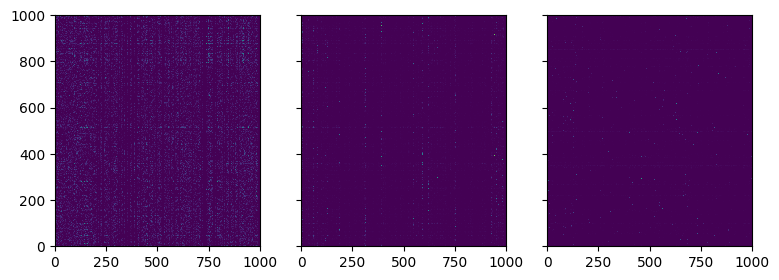

In [301]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].pcolormesh(init_activity_f[:1000,:])
axs[1].pcolormesh(init_activity_d[:1000,:])
axs[2].pcolormesh(init_activity_d_n[:1000,:])


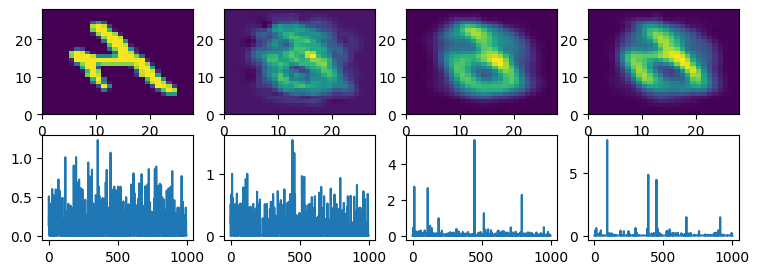

In [422]:
sample_indx = 59
recon_0 = torch.mm(torch.unsqueeze(init_activity_0[sample_indx,:], 0), torch.tensor(init_proj).T.float())
recon_f = torch.mm(torch.unsqueeze(init_activity_f[sample_indx,:], 0), torch.tensor(proj).T.float())
recon_d = torch.mm(torch.unsqueeze(init_activity_d[sample_indx,:], 0), torch.tensor(proj-init_proj).T.float())
recon_d_n = torch.mm(torch.unsqueeze(init_activity_d_n[sample_indx,:], 0), normalize(torch.tensor(proj-init_proj), p=2, dim=0).T.float())
fig, axs = plt.subplots(2, 4, figsize=(9, 3))
axs[0,0].pcolormesh(test_set[:,sample_indx].reshape(28,28))
axs[0,1].pcolormesh(recon_f.reshape(28,28))
axs[0,2].pcolormesh(recon_d.reshape(28,28))
axs[0,3].pcolormesh(recon_d_n.reshape(28,28))

axs[1,0].plot(init_activity_0[sample_indx,:], label='f')
axs[1,1].plot(init_activity_f[sample_indx,:], label='f')
axs[1,2].plot(init_activity_d[sample_indx,:], label='d')
axs[1,3].plot(init_activity_d_n[sample_indx,:], label='d_n')


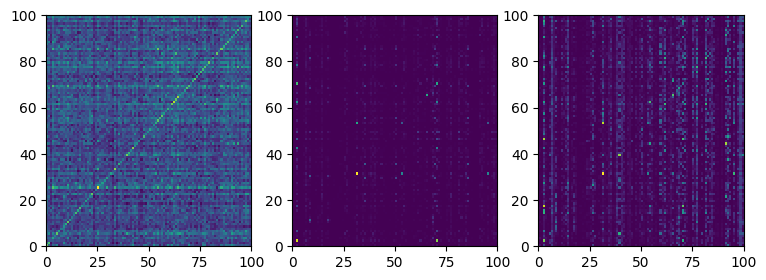

In [412]:
act_0_n = normalize(init_activity_0, p=2, dim=1)
act_f_n = normalize(init_activity_f, p=2, dim=1)
act_d_n = normalize(init_activity_d, p=2, dim=1)
act_d_n_n = normalize(init_activity_d_n, p=2, dim=1)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].pcolormesh(torch.mm(act_f_n[:100,:100], act_0_n[:100,:100].T))
axs[1].pcolormesh(torch.mm(act_d_n[:100,:100], act_d_n_n[:100,:100].T))
axs[2].pcolormesh(torch.mm(act_f_n[:100,:100], act_d_n_n[:100,:100].T))

In [384]:
module_d = DiscriminationModule(torch.randn(784, 500), mode='l')
for i, sample in enumerate(test_set.T):
    if i > 1000:
        break
    elif i > 0 and not i%100:
        print(i, end=" ")
        module_d.homeostasize() 
    
    x = torch.unsqueeze(torch.tensor(sample).float(), 0)
    module_d(x)

tensor(11176.3672)
100 tensor(1.2755)
tensor(8658.7959)
200 tensor(1.3031)
tensor(8246.8008)
300 tensor(1.1569)
tensor(7941.6216)
400 tensor(1.1705)
tensor(7764.1104)
500 tensor(1.1962)
tensor(8009.5269)
600 tensor(0.9647)
tensor(7790.3325)
700 tensor(1.0638)
tensor(7761.8740)
800 tensor(1.1544)
tensor(7850.6748)
900 tensor(1.1531)
tensor(7743.5894)
1000 tensor(0.9994)
tensor(7592.2715)


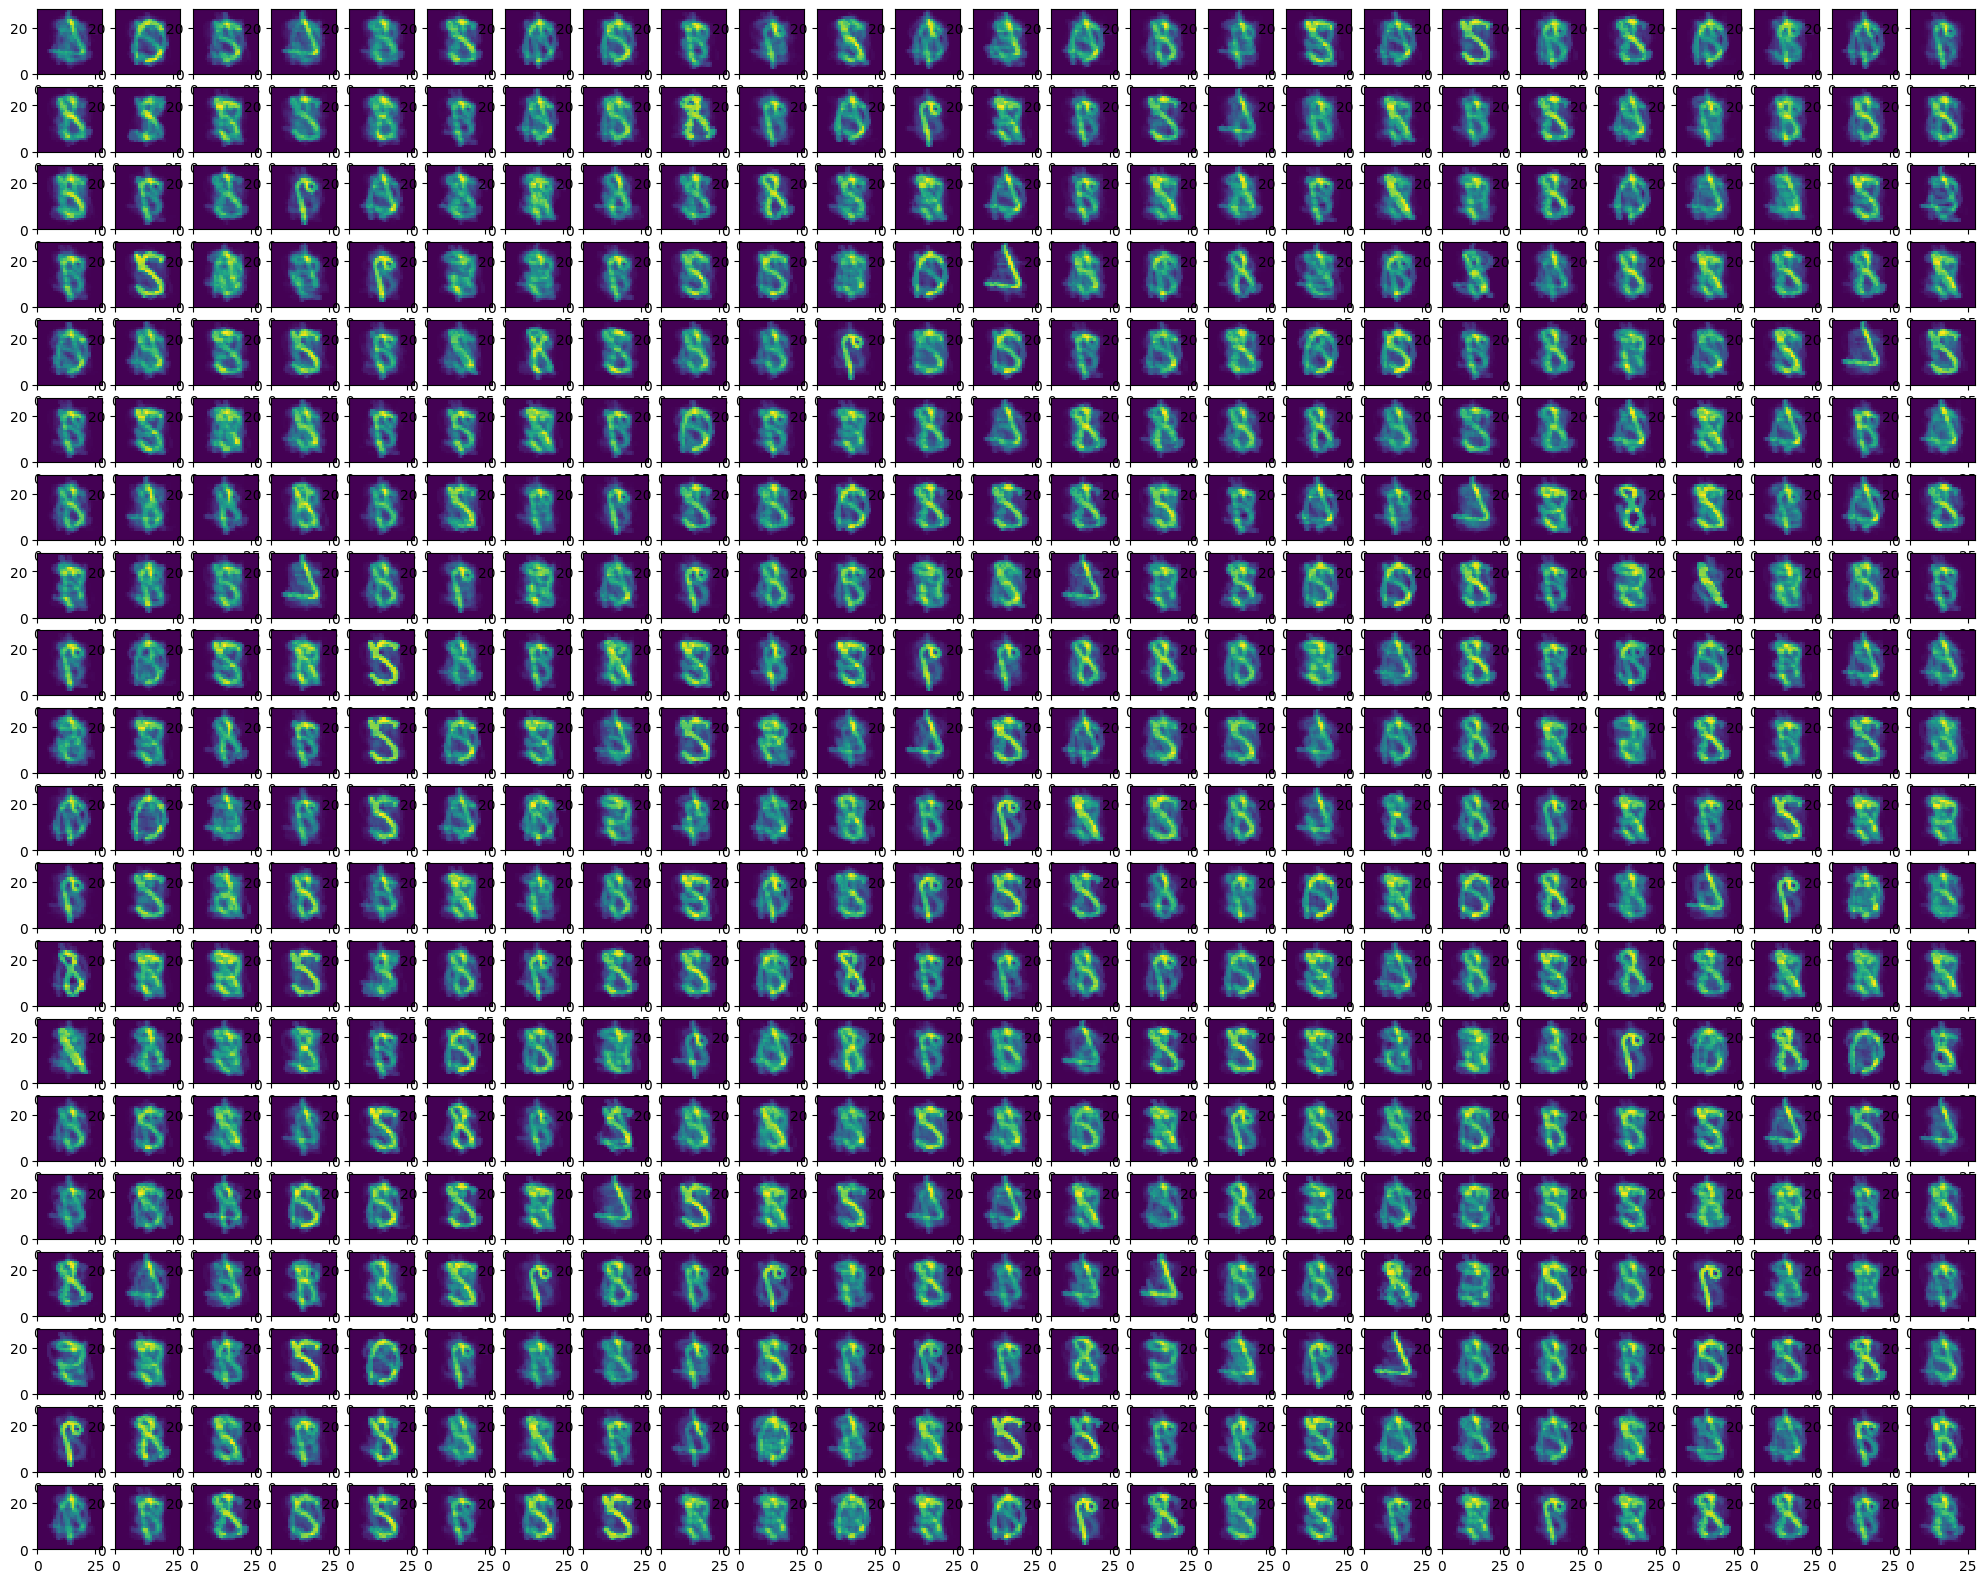

In [385]:
wf = module_d.connections()
fig, axs = plt.subplots(20, 25, figsize=(25,20))
for n in range(500):
    i, j = divmod(n,25)
    axs[i,j].pcolormesh(wf[:,n].reshape(28,28))

